In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',1000)
import os
from qvalue import estimate
from glob import iglob

/Users/mikesivley/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
mod2unp = pd.read_csv("modbase2unpac.txt",delimiter='\t')

In [4]:
# Load the ExAC nsSNV results
ns  = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-28/modbase_exac/daf_K_summary.txt",delimiter='\t')
ns  = ns.merge(mod2unp,left_on="structid",right_on="modelid")
print "Number of ModBase models evaluated:   %d"%len(ns)
wns = ns.copy()
print "Nmber of unique proteins analyzed:    %d"%len(ns.sort_values(by="Kp").drop_duplicates("unp"))
# Calculate FDR for un-weighted
ns.ix[~ns[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(ns.ix[~ns[ "Kp"].isnull(), "Kp"].values)
# Calculate FDR for weighted
wns.ix[~wns["wKp"].isnull(),"wKq"],wK_lam,wK_pi = estimate(wns.ix[~wns["wKp"].isnull(),"wKp"].values)
print "Nmber of unique significant proteins: %d"%len(ns[ns["Kq"]<0.1].drop_duplicates("unp"))

Number of ModBase models evaluated:   59178
Nmber of unique proteins analyzed:    13478
Nmber of unique significant proteins: 0


In [5]:
# Load the ClinVar pathogenic results
cv = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-21/modbase_clinvar/pathogenic_K_summary.txt",delimiter='\t')
cv = cv.merge(mod2unp,left_on="structid",right_on="modelid")
print "Number of ModBase models evaluated: %d"%len(cv)
print "NUmber of unique proteins analyzed: %d"%len(cv.sort_values(by="Kp").drop_duplicates("unp"))
cv.ix[~cv[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(cv.ix[~cv[ "Kp"].isnull(), "Kp"].values)
print "Nmber of unique significant proteins: %d"%len(cv[cv["Kq"]<0.1].drop_duplicates("unp"))

Number of ModBase models evaluated: 4298
NUmber of unique proteins analyzed: 1129
Nmber of unique significant proteins: 151


In [6]:
# Load the COSMIC somatic results
csm  = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-21/modbase_cosmic/recurrence_K_summary.txt",delimiter='\t')
csm  = csm.merge(mod2unp,left_on="structid",right_on="modelid")
wcsm = csm.copy()
print "Number of ModBase models evaluated: %d"%len(csm)
print "NUmber of unique proteins analyzed: %d"%len(csm.sort_values(by="Kp").drop_duplicates("unp"))
# Calculate FDR for un-weighted
csm.ix[~csm[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(csm.ix[~csm[ "Kp"].isnull(), "Kp"].values)
# Calculate FDR for weighted
wcsm.ix[~wcsm["wKp"].isnull(),"wKq"],wK_lam,wK_pi = estimate(wcsm.ix[~wcsm["wKp"].isnull(),"wKp"].values)
print "Nmber of unique significant proteins: %d"%len(csm[csm["Kq"]<0.1].drop_duplicates("unp"))

Number of ModBase models evaluated: 100955
NUmber of unique proteins analyzed: 16962
Nmber of unique significant proteins: 43


ValueError: min() arg is an empty sequence

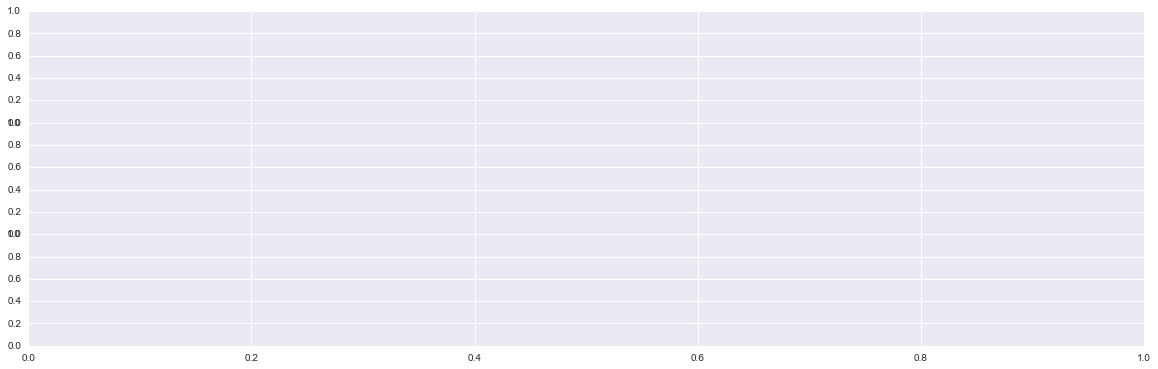

In [7]:
# Setup the plot
fig,ax = plt.subplots(3,1,figsize=(20,6),sharex=True,facecolor='white')
plt.subplots_adjust(wspace=0, hspace=0)
pal = list(sns.color_palette("Set1", n_colors=4, desat=.5))

# Plot the FDR-significant K for ExAC nsSNVs
df = ns[(ns["Kq"]<0.1) & (ns["Kz"]>0)]
df['dummy'] = ''
sns.violinplot(x='T',y='dummy',data=df,inner='quart',color=pal[0],scale='width',cut=0,ax=ax[0])
sns.stripplot(x='T',y='dummy',data=df,jitter=True,lw=2,color=pal[0],orient='h',edgecolor='white',size=10,ax=ax[0])
ax[0].set_ylabel("ExAC\nMissense",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(fontsize=20,handles=handles[:2])

# Plot the FDR-significant K for COSMIC somatic nsSNVs
df = csm[(csm["Kq"]<0.1) & (csm["Kz"]>0)]
df['dummy'] = ''
sns.violinplot(x='T',y='dummy',data=df,inner='quart',color=pal[1],scale='width',cut=0,ax=ax[1])
sns.stripplot(x='T',y='dummy',data=df,jitter=True,lw=2,color=pal[1],orient='h',edgecolor='white',size=10,ax=ax[1])
ax[1].set_ylabel("COSMIC\nSomatic",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(fontsize=20,handles=handles[:2])

# Plot the FDR-significant K for ClinVar pathogenic nsSNVs
df = cv[(cv["Kq"]<0.1) & (cv["Kz"]>0)]
df['dummy'] = ''
sns.violinplot(x='T',y='dummy',data=df,inner='quart',color=pal[2],scale='width',cut=0,ax=ax[2])
sns.stripplot(x='T',y='dummy',data=df,jitter=True,lw=2,color=pal[2],orient='h',edgecolor='white',size=10,ax=ax[2])
ax[2].set_ylabel("ClinVar\nPathogenic",fontsize=25,rotation='horizontal',ha='right')
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(fontsize=20,handles=handles[:2])

plt.rcParams['xtick.labelsize'] = 20
plt.xlabel("Optimal Distance Threshold",fontsize=23)
for x in ax:
    x.axvline(x=10,c='darkorange',ls='dashed',lw=3)
plt.xlim([0,70])
plt.suptitle("Optimal Distance Thresholds for Proteins with Significant Clustering",fontsize=28,y=0.97)
plt.show()

In [ ]:
print len(ns.ix[(ns["Kq"]<0.1) & (ns["Kz"]>0),"unp"].drop_duplicates())
print len(csm.ix[(csm["Kq"]<0.1) & (csm["Kz"]>0),"unp"].drop_duplicates())
print len(cv.ix[(cv["Kq"]<0.1) & (cv["Kz"]>0),"unp"].drop_duplicates())

In [ ]:
from scipy.stats import mannwhitneyu
print "Mann-Whitney U Comparisons"
u,p = mannwhitneyu(ns.ix[(ns["Kq"]<0.1) & (ns["Kz"]>0),"Kz"],csm.ix[(csm["Kq"]<0.1) & (csm["Kz"]>0),"Kz"])
print "Nonsynonymous-COSMIC:      p = %4.2g"%p
u,p = mannwhitneyu(ns.ix[(ns["Kq"]<0.1) & (ns["Kz"]>0),"Kz"],cv.ix[(cv["Kq"]<0.1) & (cv["Kz"]>0),"Kz"])
print "Nonsynonymous-ClinVar:     p = %4.2g"%p
u,p = mannwhitneyu(csm.ix[(csm["Kq"]<0.1) & (csm["Kz"]>0),"Kz"],cv.ix[(cv["Kq"]<0.1) & (cv["Kz"]>0),"Kz"])
print "COSMIC-ClinVar:            p = %4.2g"%p

In [ ]:
print ns.ix[(ns["Kq"]<0.1) & (ns["T"]>60),["structid","chain"]]

In [ ]:
print "Optimal Threshold Medians:"
print "ExAC:    %2d"%ns.ix[(ns["Kq"]<0.1)  & (ns["Kz"]>0),"T"].median()
print "COSMIC:  %2d"%csm.ix[(csm["Kq"]<0.1) & (csm["Kz"]>0),"T"].median()
print "ClinVar: %2d"%cv.ix[(cv["Kq"]<0.1)  & (cv["Kz"]>0),"T"].median()

In [ ]:
print "Proportion of Optimal Thresholds > 10 Angstroms:"
print "ExAC:    %.2f"%(((ns["Kq"]<0.1) & (ns["Kz"]>0) & (ns["T"]>10.)).sum()/float(((ns["Kq"]<0.1) & (ns["Kz"]>0)).sum()))
print "COSMIC:  %.2f"%(((csm["Kq"]<0.1) & (csm["Kz"]>0) & (csm["T"]>10.)).sum()/float(((csm["Kq"]<0.1) & (csm["Kz"]>0)).sum()))
print "ClinVar: %.2f"%(((cv["Kq"]<0.1) & (cv["Kz"]>0) & (cv["T"]>10.)).sum()/float(((cv["Kq"]<0.1) & (cv["Kz"]>0)).sum()))

In [ ]:
# Wilcoxon Rank Sum test
from scipy.stats import mannwhitneyu
print "Mann-Whitney U Tests for Optimal Distance Threshold Distributions:\n"

u,p = mannwhitneyu(ns.ix[(ns["Kq"]<0.1) & (ns["Kz"]>0),"T"],csm.ix[(csm["Kq"]<0.1) & (csm["Kz"]>0),"T"])
print "ExAC-COSMIC:    U=%6.1f p=%.3g"%(u,p)

u,p = mannwhitneyu(ns.ix[(ns["Kq"]<0.1) & (ns["Kz"]>0),"T"],cv.ix[(cv["Kq"]<0.1) & (cv["Kz"]>0),"T"])
print "ExAC-ClinVar:   U=%6.1f p=%.3g"%(u,p)

u,p = mannwhitneyu(csm.ix[(csm["Kq"]<0.1) & (csm["Kz"]>0),"T"],cv.ix[cv["Kq"]<0.1,"T"])
print "COSMIC-Clinvar: U=%6.1f p=%.3g"%(u,p)